In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u

import healpy as hp

from fgbuster import (CMB, Dust, Synchrotron,xForecast,
                      basic_comp_sep,get_sky,
                      get_observation, get_instrument,get_noise_realization)
from fgbuster.visualization import corner_norm

from functools import partial
from scipy.interpolate import griddata
from skimage.restoration import inpaint

import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

Mappa originale in 1D -> Q_40

Mappa con patch originale 2D -> maps_2d['mp_hp_Q40']

Mappa (patch) con beam 2D -> Q_conv_real_40

Mappa (patch) con beam + angle 2D -> Q_polangle_40

Mappa (patch) con beam + angle + ap 2D -> Q_ap_40

Mappa (patch) con beam + angle + ap 1D -> flatten_maps['Q_flat40']

CMB (patch) con beam + angle + ap 1D -> cmb_I

CMB (patch) con beam + angle + ap 2D -> cmb_I_2d

CMB (patch) deconvoluta 2D -> I_deconv

# Inizializzazione mappa

In [2]:
nside = 64

sky = get_sky(nside, 'd1s1')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)


pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


In [3]:
# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


##############################################################

I40 = mappa40[0,:]
Q40 = mappa40[1,:]
U40 = mappa40[2,:]

I60 = mappa60[0,:]
Q60 = mappa60[1,:]
U60 = mappa60[2,:]

I78 = mappa78[0,:]
Q78 = mappa78[1,:]
U78 = mappa78[2,:]

I100 = mappa100[0,:]
Q100 = mappa100[1,:]
U100 = mappa100[2,:]

I140 = mappa140[0,:]
Q140 = mappa140[1,:]
U140 = mappa140[2,:]

I195 = mappa195[0,:]
Q195 = mappa195[1,:]
U195 = mappa195[2,:]

I280 = mappa280[0,:]
Q280 = mappa280[1,:]
U280 = mappa280[2,:]

I402 = mappa402[0,:]
Q402 = mappa402[1,:]
U402 = mappa402[2,:]

np.shape(I40)

(49152,)

# Creazione patch

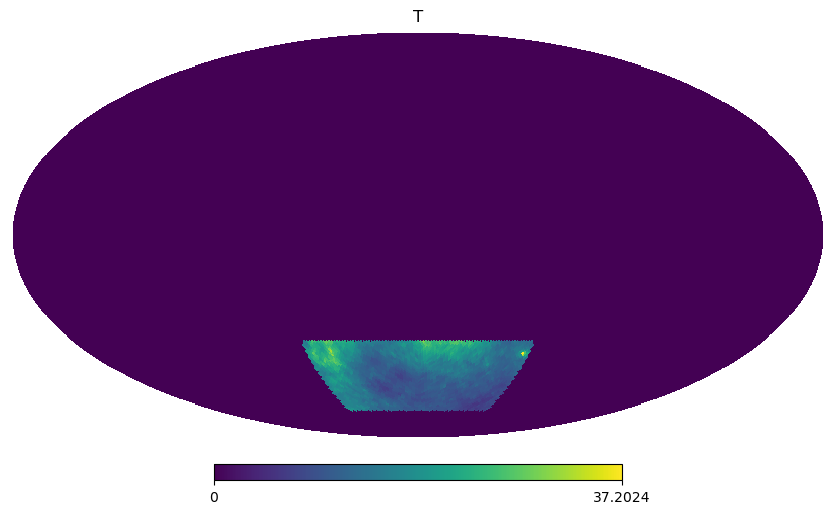

In [4]:
# patch
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40
idxs, resol = create_rectangular_patch([RA1, RA2], [dec1, dec2], nside)

##############################################################################


map_array= [I40, Q40, U40, 
            I60, Q60, U60, 
            I78, Q78, U78, 
            I100, Q100, U100, 
            I140, Q140, U140, 
            I195, Q195, U195, 
            I280, Q280, U280, 
            I402, Q402, U402 ]


for map in map_array:

    visualize_patch = map.copy()

    mask = np.zeros_like(visualize_patch, dtype=bool)
    mask[idxs] = True

    visualize_patch[~mask] = hp.UNSEEN

    map[~mask] = 0.0
    
    
    
hp.mollview(I40, title='T')

### Conversion 1D -> 2D

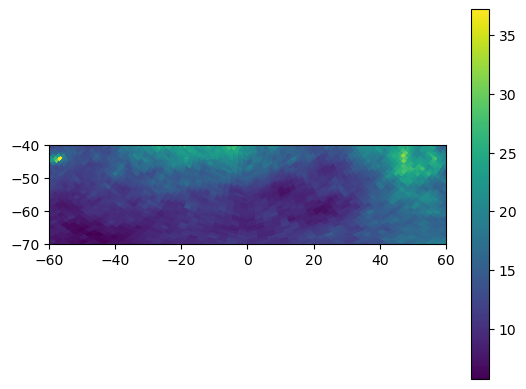

In [5]:
maps_2d = {}
extent=(RA1, RA2, dec1, dec2)

bands = ['40', '60', '78', '100', '140', '195', '280', '402']
types = ['I', 'Q', 'U']


for band in bands:
    for map_type in types:
        map_name = f"{map_type}{band}"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}{band}"
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp
        #print(f"Stored variables for: {variable_prefix}") 

        
plt.figure()
plt.imshow(maps_2d['mp_hp_I40'],origin='lower', extent=extent)
plt.colorbar()

# DIMENSIONI MAPPE

In [6]:
Ny, Nx = np.shape(maps_2d['mp_hp_I40']) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  

393 99


# Beam

### MC

In [7]:
import random 
num_simulations = 10

FWHM_err =np.sort([random.uniform(-1, 1) for _ in range(num_simulations)])
FWHM_err

array([-0.80846111, -0.68553462, -0.65897085, -0.63716722, -0.61854382,
       -0.36813816, -0.21616749, -0.20092361,  0.02512203,  0.29567576])

In [8]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = np.zeros(num_simulations)
FWHM_y = np.zeros(num_simulations)

for i in range (num_simulations):
    FWHM_x[i] = 40  + FWHM_err[i] #degrees
    FWHM_y[i] = 60  + FWHM_err[i] #degrees

    
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22, -24, -26]) #max values of the secondary peaks
array_dB = array_dB * 2.5
r1 = np.array([80000, 200000, 300000, 400000]) #angular distance of the peaks
r = 100 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 

#########################################################################################

# BEAM

beam_x = {}

for i in range(num_simulations):
        _, _, _,_, beam_x[i], _ = create_beam_secpeaks(pix_size, FWHM_x[i], FWHM_y[i], theta, array_dB, r, r1, X, Y, a, ellipticity[i])
        


ellipticity =  [-0.20328699 -0.20278026 -0.20267109 -0.20258157 -0.20250517 -0.20148348
 -0.20086842 -0.20080694 -0.19989956 -0.19882425]


beam max: 4.342923104481638e-05 beam min: 0.8217838324445186


0

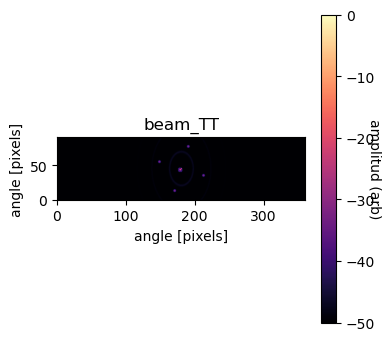

In [9]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":105.5,"R":2000.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":200.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 100.,"N":1,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam_sys = BeamSystematics()

beam_TT = {}
beam_QQ = {}
beam_UU = {}

for i in range(num_simulations):
        beam_TT[i], beam_QQ[i], beam_UU[i], _, _, _, _ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x[i], beam_x[i], bs)


######################################################################################################################################
beam_to_plot = beam_TT[0]
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width, Y_width,  "beam_TT", 'angle [pixels]')

In [10]:
frequencies = [40, 60, 78, 100, 140, 195, 280, 402]

I_maps = {
    40: maps_2d['mp_hp_I40'], 60: maps_2d['mp_hp_I60'], 78: maps_2d['mp_hp_I78'],
    100: maps_2d['mp_hp_I100'], 140: maps_2d['mp_hp_I140'], 195: maps_2d['mp_hp_I195'],
    280: maps_2d['mp_hp_I280'], 402: maps_2d['mp_hp_I402']}


Q_maps = {
    40: maps_2d['mp_hp_Q40'], 60: maps_2d['mp_hp_Q60'], 78: maps_2d['mp_hp_Q78'],
    100: maps_2d['mp_hp_Q100'], 140: maps_2d['mp_hp_Q140'], 195: maps_2d['mp_hp_Q195'],
    280: maps_2d['mp_hp_Q280'], 402: maps_2d['mp_hp_Q402']}

U_maps = {
    40: maps_2d['mp_hp_U40'], 60: maps_2d['mp_hp_U60'], 78: maps_2d['mp_hp_U78'],
    100: maps_2d['mp_hp_U100'], 140: maps_2d['mp_hp_U140'], 195: maps_2d['mp_hp_U195'],
    280: maps_2d['mp_hp_U280'], 402: maps_2d['mp_hp_U402']}

In [11]:
# convolution with perfect beam
perf_beam = {}
 

for i in range(num_simulations):
    perf_beam[i], _, _, _, _, _ = create_beam_secpeaks(pix_size, FWHM_x[i], FWHM_y[i], 0, array_dB, r, r1, X, Y, a, ellipticity[i])
    perf_beam[i] = perf_beam[i] / np.sum(perf_beam[i])


Q_conv_perf_all = {}
U_conv_perf_all = {}

for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]

    Q_conv_perf  = np.zeros((num_simulations, *Q_map.shape))
    U_conv_perf  = np.zeros((num_simulations, *U_map.shape))

    
    for i in range(num_simulations):
        Q_conv_perf[i, :, :] = convolve_map_with_beam(Q_map, perf_beam[i])
        U_conv_perf[i, :, :] = convolve_map_with_beam(U_map, perf_beam[i])
        
    Q_conv_perf_all[freq] = Q_conv_perf
    U_conv_perf_all[freq] = U_conv_perf

    
    
# convolution with real beam
Q_conv_real_all = {}
U_conv_real_all = {}
I_conv_real_all = {}
    
for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]
    I_map = I_maps[freq]

    I_conv_real  = np.zeros((num_simulations, *I_map.shape))
    Q_conv_real  = np.zeros((num_simulations, *Q_map.shape))
    U_conv_real  = np.zeros((num_simulations, *U_map.shape))

    
    for i in range(num_simulations):
        I_conv_real[i, :, :] = convolve_map_with_beam(Q_map, beam_TT[i])
        Q_conv_real[i, :, :] = convolve_map_with_beam(Q_map, beam_QQ[i])
        U_conv_real[i, :, :] = convolve_map_with_beam(U_map, beam_UU[i])
        
    I_conv_real_all[freq] = I_conv_real
    Q_conv_real_all[freq] = Q_conv_real
    U_conv_real_all[freq] = U_conv_real

Text(0.5, 1.0, 'Simulation 1, 40 GHz, Q map')

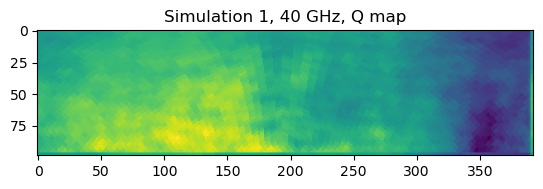

In [13]:
plt.imshow(Q_conv_real_all[40][0])
plt.title('Simulation 1, 40 GHz, Q map')

# Pol angle

In [14]:
std_deviation_degree = 1
std_deviation_rad    = std_deviation_degree * np.pi / 180
gauss_center  = 0

print(std_deviation_rad)

0.017453292519943295


In [15]:
# convolution with real beam
Q_map_perturbed_all = {}
U_map_perturbed_all = {}
    
for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]
    
    Q_pert  = np.zeros((num_simulations, *Q_map.shape))
    U_pert  = np.zeros((num_simulations, *U_map.shape))
    
    for i in range(num_simulations):
        Q_pert[i, :, :], U_pert[i, :, :] = polangle_map(Q_conv_real_all[freq][i], U_conv_real_all[freq][i], gauss_center, std_deviation_rad)
        
    Q_map_perturbed_all[freq] = Q_pert
    U_map_perturbed_all[freq] = U_pert

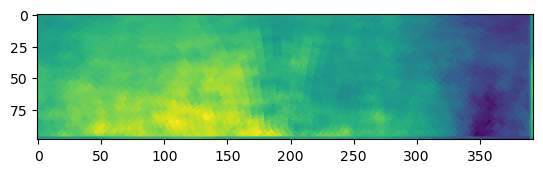

In [16]:
plt.imshow(Q_map_perturbed_all[40][0])

In [17]:
# APODIZATION
window = (cosine_window_r(Nx, Ny, x_range=[-np.pi /4, np.pi /4], y_range=[-np.pi /4, np.pi /4]))

for freq in frequencies:
    for i in range(num_simulations):
        Q_map_perturbed_all[freq][i] *= window
        U_map_perturbed_all[freq][i] *= window

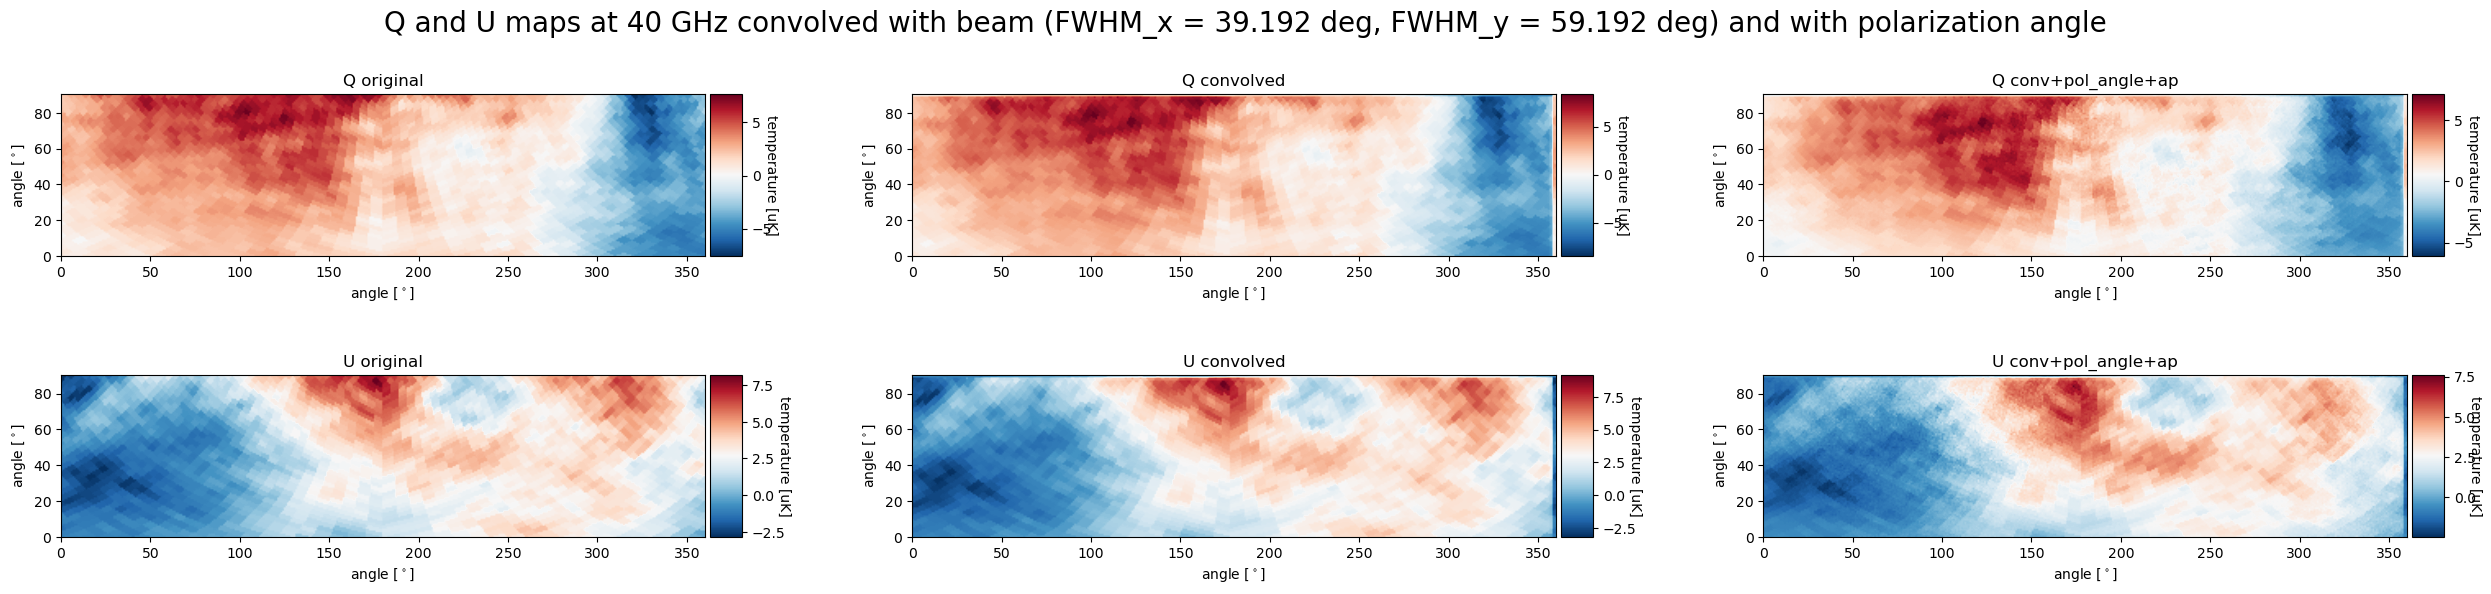

In [18]:
# plot - 1 frequenza (40) per una simulazione (1°)
Map_to_Plot = [maps_2d['mp_hp_Q40'], Q_conv_real_all[40][0], Q_map_perturbed_all[40][0], maps_2d['mp_hp_U40'], U_conv_real_all[40][0], U_map_perturbed_all[40][0]]
title = ["Q original","Q convolved", "Q conv+pol_angle+ap", "U original","U convolved", "U conv+pol_angle+ap"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]

fig, axs = plt.subplots(2, 3, figsize=(25, 6))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Q and U maps at {frequencies[0]} GHz convolved with beam (FWHM_x = {(FWHM_x[0]):.3f} deg, FWHM_y = {(FWHM_y[0]):.3f} deg) and with polarization angle', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()

# Component Separation

In [19]:
idx = hp.ang2pix(nside, ra_hp, dec_hp, lonlat=True)


Q_flat_all = {}
U_flat_all = {}

for freq in frequencies:
    Q_map = Q_map_perturbed_all[freq]
    U_map = U_map_perturbed_all[freq]
    
    Q_map_flat  = np.zeros((num_simulations,*I40.shape))
    U_map_flat  = np.zeros((num_simulations,*I40.shape))
    
    
    for i in range(num_simulations):
        new_map_Q = np.zeros_like(I40) 
        new_map_Q[idx] = Q_map_perturbed_all[freq][i].flatten()
        Q_map_flat[i] = new_map_Q  # Store the new map in the flat array
        
        
        new_map_U = np.zeros_like(I40) 
        new_map_U[idx] = U_map_perturbed_all[freq][i].flatten()
        U_map_flat[i] = new_map_U
        
        
    Q_flat_all[freq] = Q_map_flat
    U_flat_all[freq] = U_map_flat   

In [20]:
n_pixels = I40.size
Q_flat_all = {}
U_flat_all = {}

# Populate Q_flat_all and U_flat_all with flattened maps for each frequency and simulation
# Replace this with your actual code to populate Q_flat_all and U_flat_all
for freq in frequencies:
    Q_map = Q_map_perturbed_all[freq]
    U_map = U_map_perturbed_all[freq]
    
    Q_map_flat  = np.zeros((num_simulations, n_pixels))
    U_map_flat  = np.zeros((num_simulations, n_pixels))
    
    for i in range(num_simulations):
        new_map_Q = np.zeros_like(I40)
        new_map_Q[idx] = Q_map[i].flatten()
        Q_map_flat[i] = new_map_Q
        
        new_map_U = np.zeros_like(I40)
        new_map_U[idx] = U_map[i].flatten()
        U_map_flat[i] = new_map_U
        
    Q_flat_all[freq] = Q_map_flat
    U_flat_all[freq] = U_map_flat

# Now create the full_array with the desired shape (8, 2, num_simulations, 49152)
full_array = np.zeros((len(frequencies), 2, num_simulations, n_pixels))

for f_idx, freq in enumerate(frequencies):
    Q_stack = Q_flat_all[freq]
    U_stack = U_flat_all[freq]
    
    # Stack Q and U maps for the current frequency
    freq_stack = np.stack([Q_stack, U_stack], axis=0)  # Shape (2, num_simulations, 49152)
    
    # Assign to the full_array
    full_array[f_idx] = freq_stack

# Print the shape of the full_array to verify
print(full_array.shape)  # Expected shape: (8, 2, 10, 49152)

# If you want a different shape like (num_simulations, 8, 2, 49152), you can transpose it
full_array = full_array.transpose(2, 0, 1, 3)
print(full_array.shape)  # Expected shape: (10, 8, 2, 49152)

(8, 2, 10, 49152)
(10, 8, 2, 49152)


full_array contiene le 10 simulazioni , 8 frequenze, 2 mappe (Q,U) con 49152 pixels

In [21]:
np.shape(full_array[0])

(8, 2, 49152)

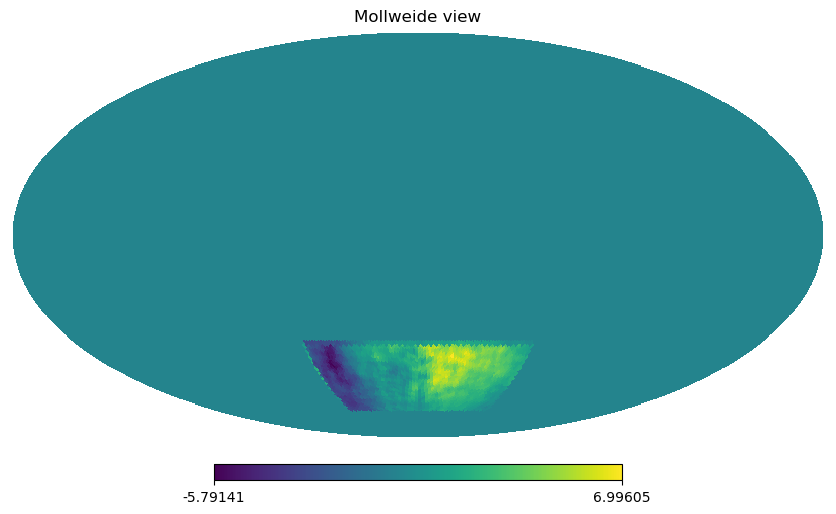

In [22]:
hp.mollview(full_array[0,0, 0]) # prova : simulazione 1°, frequenza 40, mappa Q

In [23]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
freq = df.iloc[[0, 2, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch

freq

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
10,195.0,5.85,4.14,28.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
12,280.0,13.80,9.76,22.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
14,402.0,47.45,33.55,17.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


In [24]:
components = [CMB(), Dust(350.), Synchrotron(20.)]
results = []
cmb_I = {}
cmb_Q = {}
cmb_U = {}

for i in range(num_simulations):
    result = basic_comp_sep(components, freq, full_array[i])
    results.append(result)

    # Print the results for this simulation
    print(f"Simulation {i+1}")
    print(result.params)
    print(result.x)

    #cmb_I[i]  = result.s[0, 0]
    cmb_Q[i]  = result.s[0, 0]
    cmb_U[i]  = result.s[0, 1]

Simulation 1
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.47052577 25.51831132 -2.91789351]
Simulation 2
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.51808285 22.85402477 -2.93449274]
Simulation 3
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.4459057  27.69906695 -2.94307786]
Simulation 4
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.45159619 27.4506824  -2.92114224]
Simulation 5
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.46664495 26.48488315 -2.93262676]
Simulation 6
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.47046261 25.90609222 -2.92872851]
Simulation 7
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.41908561 29.64443774 -2.92392246]
Simulation 8
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.44109957 27.80742349 -2.91260022]
Simulation 9
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.45132198 27.09431697 -2.92633301]
Simulation 10
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.456

In [25]:
np.shape(cmb_Q[0])

(49152,)

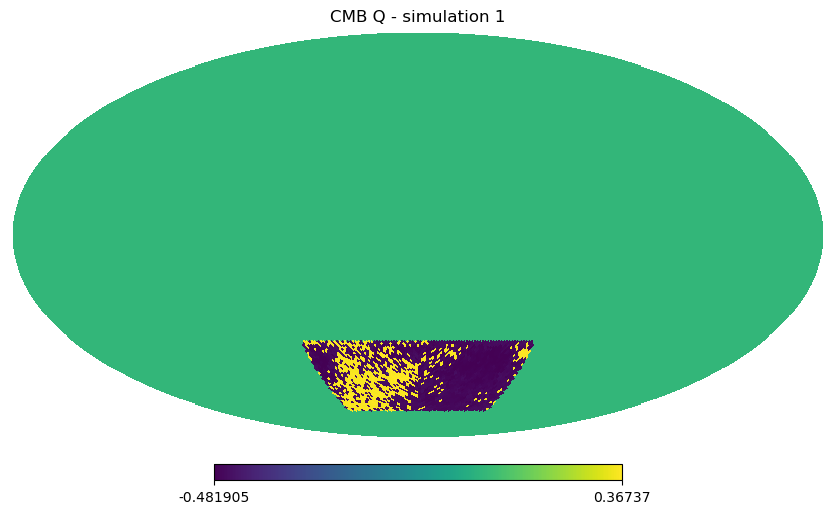

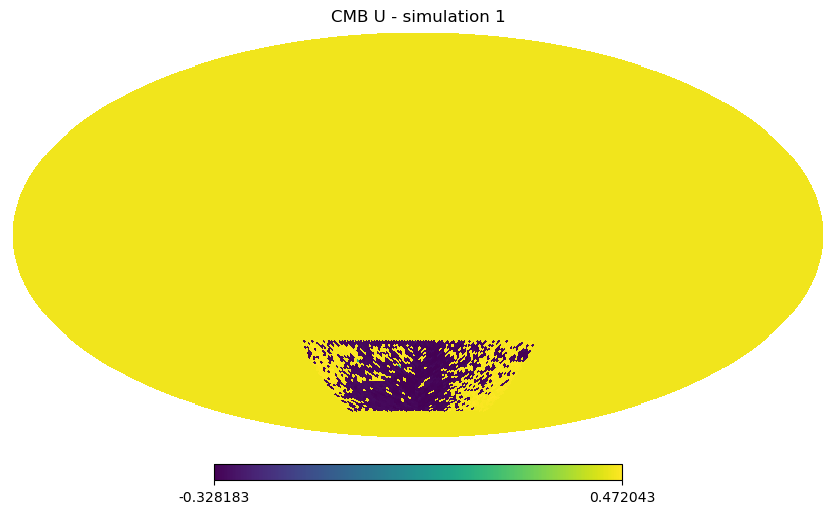

In [26]:
hp.mollview(cmb_Q[0], title='CMB Q - simulation 1', norm='hist')
hp.mollview(cmb_U[0], title='CMB U - simulation 1', norm='hist')

# Deconvolution

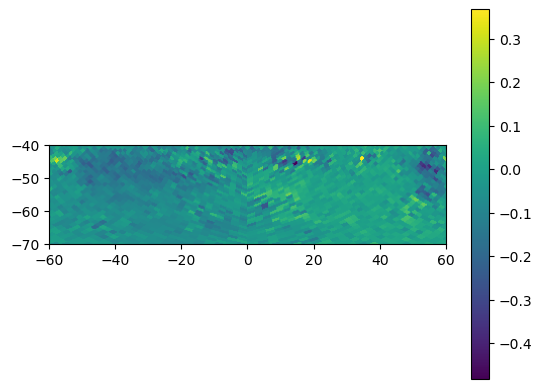

In [27]:
# torno in 2D
cmb_Q_2d = {}
cmb_U_2d = {}

for i in range (num_simulations):
    # cmb_I_2d[i], ra_hp, dec_hp = convert2grid(cmb_Q, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
    cmb_Q_2d[i], ra_hp, dec_hp = convert2grid(cmb_Q[i], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
    cmb_U_2d[i], ra_hp, dec_hp = convert2grid(cmb_U[i], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
    
plt.figure()
plt.imshow(cmb_Q_2d[0],origin='lower', extent=extent)
plt.colorbar()

In [28]:
import pymaster as nmt

In [29]:
np.shape(cmb_Q_2d[0])

(99, 393)

In [30]:
Q_deconv = {}
U_deconv = {}

for i in range (num_simulations):
    Q_deconv[i] = deconvolve_map(cmb_Q_2d[i], beam_x[i], perf_beam[i])
    U_deconv[i] = deconvolve_map(cmb_U_2d[i], beam_x[i], perf_beam[i])
    

########################################################################################
# side lobes

Q_conv_perf = {}
U_conv_perf = {}
Q_diff = {}
U_diff = {}

for i in range (num_simulations):
    Q_conv_perf[i] = convolve_map_with_beam(cmb_Q_2d[i], perf_beam[i])
    U_conv_perf[i] = convolve_map_with_beam(cmb_U_2d[i], perf_beam[i])
    
    Q_diff[i] = (Q_conv_perf[i]- Q_deconv[i])
    U_diff[i] = (U_conv_perf[i]- U_deconv[i])


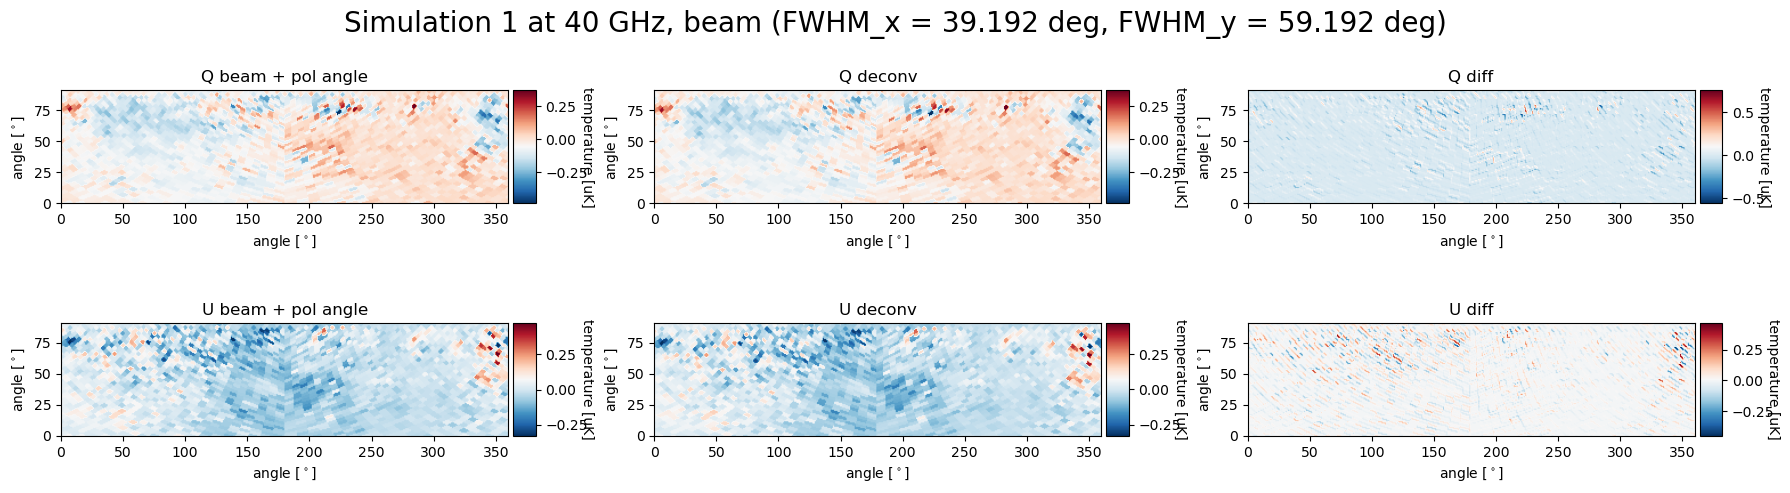

In [31]:
Map_to_Plot = [cmb_Q_2d[0],Q_deconv[0], Q_diff[0], cmb_U_2d[0] ,U_deconv[0], U_diff[0]]
title = ["Q beam + pol angle", "Q deconv", "Q diff", "U beam + pol angle", "U deconv", "U diff"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]



fig, axs = plt.subplots(2, 3, figsize=(18, 5))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Simulation 1 at {frequencies[0]} GHz, beam (FWHM_x = {(FWHM_x[0]):.3f} deg, FWHM_y = {(FWHM_y[0]):.3f} deg)', fontsize=20)


plt.show()


# Power spectra with NaMaster

In [32]:
import pymaster as nmt

pix_size_rad = np.radians(pix_size /60)

X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad


# Masks:
mask = np.ones_like(Q_deconv[0])

# bins
l0_bins = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

BB_PS = {}
EE_PS = {}

for i in range (num_simulations):
    # fields
    Q = Q_deconv[i]
    U = U_deconv[i]
    
    f2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q, U], purify_b=True)
   
    cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
    
    EE_PS[i] = cl22_coupled[0]
    BB_PS[i] = cl22_coupled[3]
    



(1.5, 500)

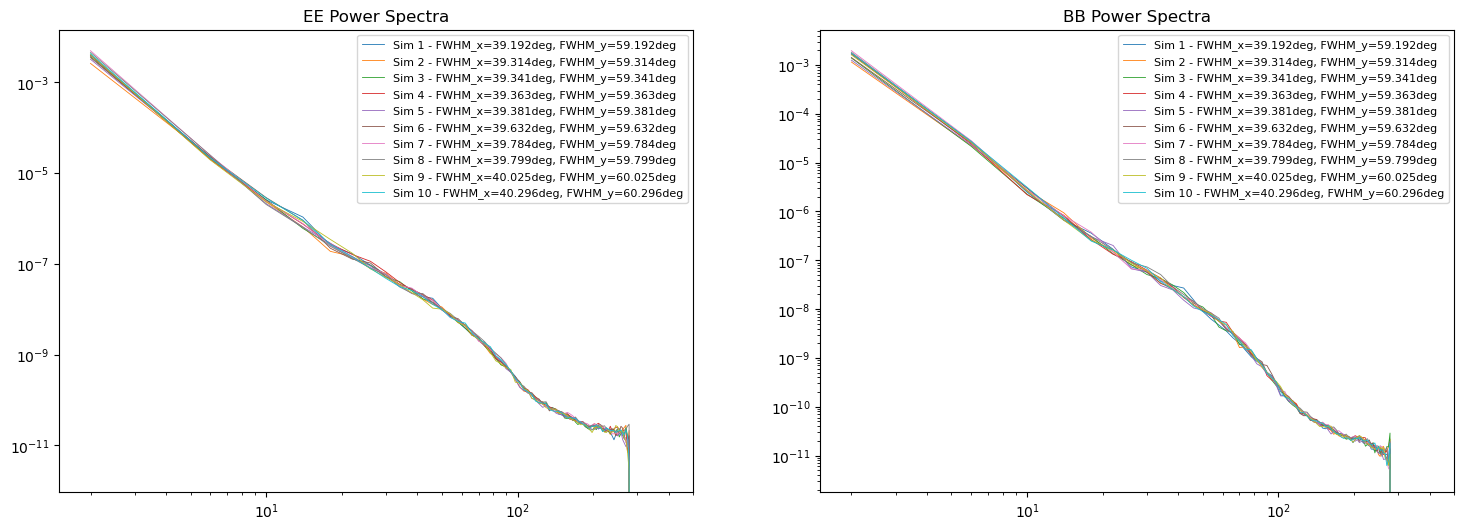

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
factor = ells_uncoupled*(ells_uncoupled+1) /(2*np.pi)


colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


# Plot EE power spectra
ax[0].set_title('EE Power Spectra')


for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[0].plot(ells_uncoupled, EE_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - FWHM_x={(FWHM_x[i]):.3f}deg, FWHM_y={(FWHM_y[i]):.3f}deg')
    
ax[0].loglog()
ax[0].legend(fontsize=8)
ax[0].set_xlim(1.5,500)

# Plot BB power spectra
ax[1].set_title('BB Power Spectra')

for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[1].plot(ells_uncoupled, BB_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - FWHM_x={(FWHM_x[i]):.3f}deg, FWHM_y={(FWHM_y[i]):.3f}deg')
    
    

    
ax[1].loglog()
ax[1].legend(fontsize=8)
ax[1].set_xlim(1.5,500)

Questi sono gli spettri delle mappe di sola CMB dopo la deconvoluzione, qunidi alla fine dell'analisi, per le 10 simulazioni

# Confronto Ps
Confronto i PS ottenuti alla fine dell'analisi con
- quelli della patch originale (quindi senza nessuna sistematica) (ma devo prima fare la comonent separation per avere la cmb)
- quelli della patch con beam+angl+ap prima della deconvoluzione (ho già la cmb)
- quelli dei side lobes

### PS patch originale
Mi servono solo 3 mappe I, Q, U e di sola cmb, quindi faccio la component separation sulle mappe (già in 1d) chiamate I40, Q_40 etc
- component separation
- trasformo in 2d
- PS

In [34]:
freq40_or = np.stack([Q40, U40])
freq60_or = np.stack([Q60, U60])
freq78_or = np.stack([Q78, U78])
freq100_or = np.stack([Q100, U100])
freq140_or = np.stack([Q140, U140])
freq195_or = np.stack([Q195, U195])
freq280_or = np.stack([Q280, U280])
freq402_or = np.stack([Q402, U402])


full_array_or = np.array([freq40_or, freq60_or, freq78_or, freq100_or, freq140_or, freq195_or, freq280_or, freq402_or])
np.shape(full_array_or)


#################################################################
components = [CMB(), Dust(350.), Synchrotron(20.)]

# component separation
result_or = basic_comp_sep(components, freq, full_array_or)

print(result_or.params)
print(result_or.x)

#cmb_I_or  = result_or.s[0,0]
cmb_Q_or  = result_or.s[0,0]
cmb_U_or  = result_or.s[0,1]

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.48832235 24.18548074 -2.94237242]


In [35]:
#cmb_I_2d_or, _, _ = convert2grid(cmb_I_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_Q_2d_or, _, _ = convert2grid(cmb_Q_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d_or, _, _ = convert2grid(cmb_U_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)

<Figure size 640x480 with 0 Axes>

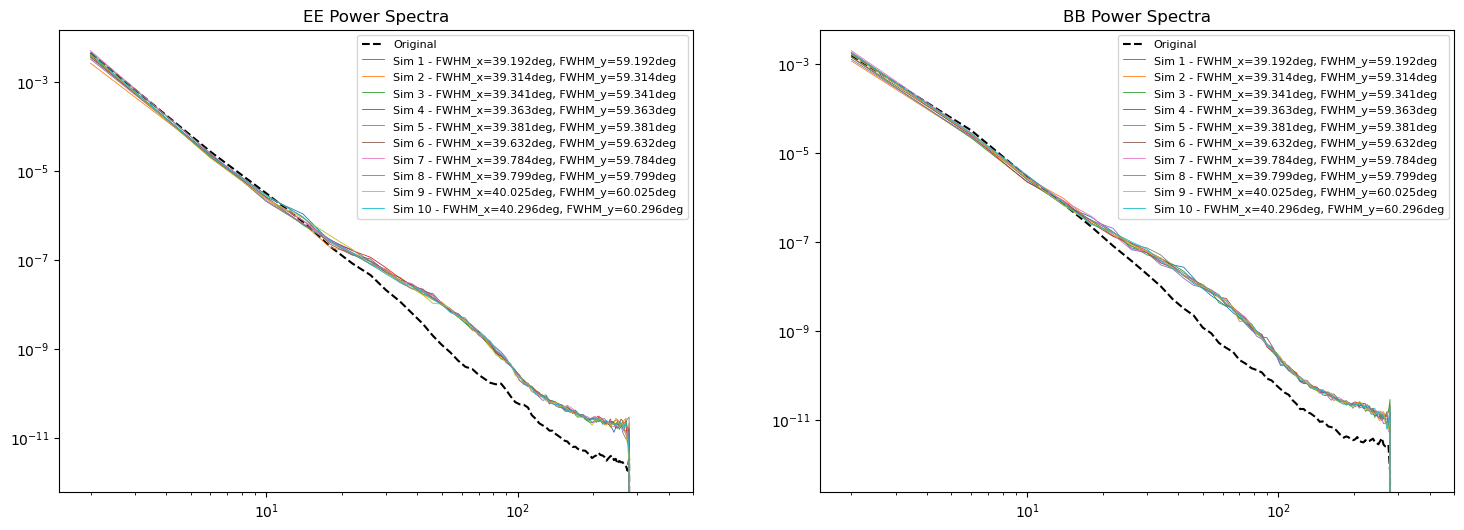

In [36]:
# Masks:
mask_or = np.ones_like(cmb_Q_2d_or)

# Fields:
#f0_or = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_I_2d_or])
f2_or = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_Q_2d_or, cmb_U_2d_or], purify_b=True)

# Bins:
l0_bins_or = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins_or = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b_or = nmt.NmtBinFlat(l0_bins_or, lf_bins_or)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled_or = b_or.get_effective_ells()

##############################################################################################################

cl22_coupled_or = nmt.compute_coupled_cell_flat(f2_or, f2_or, b_or)

########################################################################################

plt.figure()
fig, ax = plt.subplots(1,2, figsize = (18,6))


colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


# Plot EE power spectra
ax[0].set_title('EE Power Spectra')
ax[0].plot(ells_uncoupled_or, cl22_coupled_or[0]/factor, 'black', label='Original', linewidth=1.5, linestyle='--')

for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[0].plot(ells_uncoupled, EE_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - FWHM_x={(FWHM_x[i]):.3f}deg, FWHM_y={(FWHM_y[i]):.3f}deg')
    
ax[0].loglog()
ax[0].legend(fontsize=8)
ax[0].set_xlim(1.5,500)


# Plot BB power spectra
ax[1].set_title('BB Power Spectra')
ax[1].plot(ells_uncoupled_or, cl22_coupled_or[3]/factor, 'black', label='Original', linewidth=1.5, linestyle='--')

for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[1].plot(ells_uncoupled, BB_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - FWHM_x={(FWHM_x[i]):.3f}deg, FWHM_y={(FWHM_y[i]):.3f}deg')
    
ax[1].loglog()
ax[1].legend(fontsize=8)
ax[1].set_xlim(1.5,500)


plt.show()

### r forecast

In [40]:
def xForecast(components, instrument, d_fgs, lmin, lmax,
              Alens=1.0, r=0.001, make_figure=False,
              **minimize_kwargs):
    from fgbuster import  CMB, Dust, Synchrotron, algebra, mixingmatrix, observation_helpers
    import os.path as op
    import numpy as np
    import pylab as pl
    import healpy as hp
    import scipy as sp
    from fgbuster.algebra import comp_sep, W_dBdB, W_dB, W, _mmm, _utmv, _mmv
    from fgbuster.mixingmatrix import MixingMatrix
    from fgbuster.observation_helpers import standardize_instrument
    from fgbuster.cosmology import _get_Cl_noise,_get_Cl_cmb
    import inspect
    from time import time
    import six
    import numpy as np
    import scipy as sp
    import numdifftools
    from functools import reduce
   
    
    # Preliminaries
    instrument = standardize_instrument(instrument)
    nside = hp.npix2nside(d_fgs.shape[-1])
    n_stokes = d_fgs.shape[1]
    n_freqs = d_fgs.shape[0]
    invN = np.diag(hp.nside2resol(nside, arcmin=True) / (instrument.depth_p))**2
    mask = d_fgs[0, 0, :] != 0.
    fsky = mask.astype(float).sum() / mask.size
    ell = np.arange(lmin, lmax+1)
    #print('fsky = ', fsky)

    ############################################################################
    # 1. Component separation using the noise-free foregrounds templare
    # grab the max-L spectra parameters with the associated error bars
    #print('======= ESTIMATION OF SPECTRAL PARAMETERS =======')
    A = MixingMatrix(*components)
    A_ev = A.evaluator(instrument.frequency)
    A_dB_ev = A.diff_evaluator(instrument.frequency)

    x0 = np.array([x for c in components for x in c.defaults])
    if n_stokes == 3:  # if T and P were provided, extract P
        d_comp_sep = d_fgs[:, 1:, :]
    else:
        d_comp_sep = d_fgs

    res = comp_sep(A_ev, d_comp_sep.T, invN, A_dB_ev, A.comp_of_dB, x0,
                   **minimize_kwargs)

    res.params = A.params
    res.s = res.s.T
    A_maxL = A_ev(res.x)
    A_dB_maxL = A_dB_ev(res.x)
    A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(res.x)

    #print('res.x = ', res.x)

    ############################################################################
    # 2. Estimate noise after component separation
    ### A^T N_ell^-1 A
    #print('======= ESTIMATION OF NOISE AFTER COMP SEP =======')
    i_cmb = A.components.index('CMB')
    Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[i_cmb, i_cmb, lmin:]

    ############################################################################
    # 3. Compute spectra of the input foregrounds maps
    ### TO DO: which size for Cl_fgs??? N_spec != 1 ? 
    #print ('======= COMPUTATION OF CL_FGS =======')
    if n_stokes == 3:  
        d_spectra = d_fgs
    else:  # Only P is provided, add T for map2alm
        d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
        d_spectra[:, 1:] = d_fgs

    # Compute cross-spectra
    almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
    Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
    for f1 in range(n_freqs):
        for f2 in range(n_freqs):
            if f1 > f2:
                Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
            else:
                Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

    Cl_fgs = Cl_fgs[..., lmin:] / fsky

    ############################################################################
    # 4. Estimate the statistical and systematic foregrounds residuals
    #print('======= ESTIMATION OF STAT AND SYS RESIDUALS =======')

    W_maxL = W(A_maxL, invN=invN)[i_cmb, :]
    W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, i_cmb]
    W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,
                         A.comp_of_dB, invN=invN)[:, :, i_cmb]
    V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)

    # Check dimentions
    assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
                       == W_dBdB_maxL.shape[2:] == V_maxL.shape)
    assert (len(res.params) == W_dB_maxL.shape[0] 
                            == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

    # elementary quantities defined in Stompor, Errard, Poletti (2016)
    Cl_xF = {}
    Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
    Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
    Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
    Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
    Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

    # bias and statistical foregrounds residuals
    res.noise = Cl_noise
    res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
    res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
    res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                          Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

    ###############################################################################
    # 5. Plug into the cosmological likelihood
    #print ('======= OPTIMIZATION OF COSMO LIKELIHOOD =======')
    Cl_fid = {}
    Cl_fid['BB'] = _get_Cl_cmb(Alens=Alens, r=r)[2][lmin:lmax+1]
    Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
    Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]

    res.BB = Cl_fid['BB']*1.0
    res.BuBu = Cl_fid['BuBu']*1.0
    res.BlBl = Cl_fid['BlBl']*1.0
    res.ell = ell
    if make_figure:
        fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
        ax = pl.gca()
        left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
        ax0 = fig.add_axes([left, bottom, width, height])
        ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+\
            r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)

        ax.loglog(ell, Cl_fid['BB'], color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
        ax.loglog(ell, Cl_fid['BuBu']*r , color='DarkGray', linestyle='--', label='primordial BB for r='+str(r), linewidth=2.0)
        ax.loglog(ell, res.stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
        ax.loglog(ell, res.bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
        ax.loglog(ell, res.noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
        ax.legend()
        ax.set_xlabel('$\ell$', fontsize=20)
        ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
        ax.set_xlim(lmin,lmax)

    ## 5.1. data 
    Cl_obs = Cl_fid['BB'] + Cl_noise
    dof = (2 * ell + 1) * fsky
    YY = Cl_xF['YY']
    tr_SigmaYY = np.einsum('ij, lji -> l', res.Sigma, YY)

    ## 5.2. modeling
    def cosmo_likelihood(r_):
        # S16, Appendix C
        Cl_model = Cl_fid['BlBl'] * Alens + Cl_fid['BuBu'] * r_ + Cl_noise
        dof_over_Cl = dof / Cl_model
        ## Eq. C3
        U = np.linalg.inv(res.Sigma_inv + np.dot(YY.T, dof_over_Cl))
        
        ## Eq. C9
        first_row = np.sum(dof_over_Cl * (
            Cl_obs * (1 - np.einsum('ij, lji -> l', U, YY) / Cl_model) 
            + tr_SigmaYY))
        second_row = - np.einsum(
            'l, m, ij, mjk, kf, lfi',
            dof_over_Cl, dof_over_Cl, U, YY, res.Sigma, YY)
        trCinvC = first_row + second_row
       
        ## Eq. C10
        first_row = np.sum(dof_over_Cl * (Cl_xF['yy'] + 2 * Cl_xF['yz']))
        ### Cyclicity + traspose of scalar + grouping terms -> trace becomes
        ### Yy_ell^T U (Yy + 2 Yz)_ell'
        trace = np.einsum('li, ij, mj -> lm',
                          Cl_xF['Yy'], U, Cl_xF['Yy'] + 2 * Cl_xF['Yz'])
        second_row = - _utmv(dof_over_Cl, trace, dof_over_Cl)
        trECinvC = first_row + second_row

        ## Eq. C12
        logdetC = np.sum(dof * np.log(Cl_model)) - np.log(np.linalg.det(U))

        # Cl_hat = Cl_obs + tr_SigmaYY

        ## Bringing things together
        return trCinvC + trECinvC + logdetC


    # Likelihood maximization
    r_grid = np.logspace(-5,0,num=500)
    logL = np.array([cosmo_likelihood(r_loc) for r_loc in r_grid])
    ind_r_min = np.argmin(logL)
    r0 = r_grid[ind_r_min]
    if ind_r_min == 0:
        bound_0 = 0.0
        bound_1 = r_grid[1]
        # pl.figure()
        # pl.semilogx(r_grid, logL, 'r-')
        # pl.show()
    elif ind_r_min == len(r_grid)-1:
        bound_0 = r_grid[-2]
        bound_1 = 1.0
        # pl.figure()
        # pl.semilogx(r_grid, logL, 'r-')
        # pl.show()
    else:
        bound_0 = r_grid[ind_r_min-1]
        bound_1 = r_grid[ind_r_min+1]
    #print('bounds on r = ', bound_0, ' / ', bound_1)
    #print('starting point = ', r0)
    res_Lr = sp.optimize.minimize(cosmo_likelihood, [r0], bounds=[(bound_0,bound_1)], **minimize_kwargs)
    #print ('    ===>> fitted r = ', res_Lr['x'])

    #print ('======= ESTIMATION OF SIGMA(R) =======')
    def sigma_r_computation_from_logL(r_loc):
        THRESHOLD = 1.00
        # THRESHOLD = 2.30 when two fitted parameters
        delta = np.abs( cosmo_likelihood(r_loc) - res_Lr['fun'] - THRESHOLD )
        # print r_loc, cosmo_likelihood(r_loc),  res_Lr['fun']
        return delta

    if res_Lr['x'] != 0.0:
        sr_grid = np.logspace(np.log10(res_Lr['x']), 0, num=25)
    else:
        sr_grid = np.logspace(-5,0,num=25)

    slogL = np.array([sigma_r_computation_from_logL(sr_loc) for sr_loc in sr_grid ])
    ind_sr_min = np.argmin(slogL)
    sr0 = sr_grid[ind_sr_min]
    #print('ind_sr_min = ', ind_sr_min)
    #print('sr_grid[ind_sr_min-1] = ', sr_grid[ind_sr_min-1])
    #print('sr_grid[ind_sr_min+1] = ', sr_grid[ind_sr_min+1])
    #print('sr_grid = ', sr_grid)
    if ind_sr_min == 0:
        #print('case # 1')
        bound_0 = res_Lr['x']
        bound_1 = sr_grid[1]
    elif ind_sr_min == len(sr_grid)-1:
        #print('case # 2')
        bound_0 = sr_grid[-2]
        bound_1 = 1.0
    else:
        #print('case # 3')
        bound_0 = sr_grid[ind_sr_min-1]
        bound_1 = sr_grid[ind_sr_min+1]
    #print('bounds on sigma(r) = ', bound_0, ' / ', bound_1)
    #print('starting point = ', sr0)
    res_sr = sp.optimize.minimize(sigma_r_computation_from_logL, sr0,
            bounds=[(bound_0.item(),bound_1.item())],
            # item required for test to pass but reason unclear. sr_grid has
            # extra dimension?
            **minimize_kwargs)
    #res_sigma = res_sr['x'] -  res_Lr['x']
    #print ('    ===>> sigma(r) = ', res_sr['x'] -  res_Lr['x'])
    res.cosmo_params = {}
    res.cosmo_params['r'] = (res_Lr['x'], res_sr['x']- res_Lr['x'])


    ###############################################################################
    # 6. Produce figures
    if make_figure:
        #print ('======= GRIDDING COSMO LIKELIHOOD =======')
        r_grid = np.logspace(-4,-1,num=500)
        logL = np.array([ cosmo_likelihood(r_loc) for r_loc in r_grid ])
        chi2 = logL - np.min(logL)
        ax0.semilogx( r_grid,  np.exp(-chi2), color='DarkOrange', linestyle='-', linewidth=2.0, alpha=0.8 )
        ax0.axvline(x=r, color='k', linestyle='--')
        ax0.set_ylabel(r'$\mathcal{L}(r)$', fontsize=20)
        ax0.set_xlabel(r'tensor-to-scalar ratio $r$', fontsize=20)
        pl.show()

    return res

In [38]:
res = {}
sigma_r = np.zeros(num_simulations)


for i in range(num_simulations):
    print(f'SIMULATION {i+1}, FWHM_x={(FWHM_x[i]):.3f}deg, FWHM_y={(FWHM_y[i]):.3f}deg')
    res[i] = xForecast(components, freq, full_array[i], 2, 2*nside-1, Alens=0.1, r=0.01, make_figure=False)

SIMULATION 1, FWHM_x=39.192deg, FWHM_y=59.192deg
SIMULATION 2, FWHM_x=39.314deg, FWHM_y=59.314deg
SIMULATION 3, FWHM_x=39.341deg, FWHM_y=59.341deg
SIMULATION 4, FWHM_x=39.363deg, FWHM_y=59.363deg
SIMULATION 5, FWHM_x=39.381deg, FWHM_y=59.381deg
SIMULATION 6, FWHM_x=39.632deg, FWHM_y=59.632deg
SIMULATION 7, FWHM_x=39.784deg, FWHM_y=59.784deg
SIMULATION 8, FWHM_x=39.799deg, FWHM_y=59.799deg
SIMULATION 9, FWHM_x=40.025deg, FWHM_y=60.025deg
SIMULATION 10, FWHM_x=40.296deg, FWHM_y=60.296deg


In [39]:
r = []
sigma_r = []

for i in range(num_simulations):
    res[i].cosmo_params['r'] = np.array(res[i].cosmo_params['r'])
    r.append(res[i].cosmo_params['r'][0][0])
    sigma_r.append(res[i].cosmo_params['r'][1][0])
    print(f'Simulation {i+1}: FWHM_x={(FWHM_x[0]):.3f}deg, FWHM_y={(FWHM_y[0]):.3f}deg, r = {r[i]:.5f}, sigma_r = {sigma_r[i]:.5f}')
    
r = np.array(r)
sigma_r = np.array(sigma_r)

Simulation 1: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03339, sigma_r = 0.00000
Simulation 2: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03176, sigma_r = 0.00286
Simulation 3: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03027, sigma_r = 0.00277
Simulation 4: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03210, sigma_r = 0.00000
Simulation 5: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03107, sigma_r = 0.00000
Simulation 6: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03235, sigma_r = 0.00287
Simulation 7: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03193, sigma_r = 0.00000
Simulation 8: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03180, sigma_r = 0.00000
Simulation 9: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03122, sigma_r = 0.00000
Simulation 10: FWHM_x=39.192deg, FWHM_y=59.192deg, r = 0.03245, sigma_r = 0.00288


Sigma r è calcolato male